# DeepFreq v.s. Other Frequency Representation Methods

In [45]:
import os
import numpy as np
import torch
import util
import matplotlib.pyplot as plt
import cvxpy as cp

from numpy import fft
from scipy.linalg import dft, hankel, svd, norm, pinv
from scipy.signal import find_peaks
from data import fr

from IPython.display import clear_output
%matplotlib inline

In [46]:
def snr(signal, noise):
    return 20 * np.log10(norm(signal) / norm(noise))
def buildOnGridSinusoid(N, M, sig, c, th_ind):
    
    # Build complex noise
    n = np.zeros((M, 1)).astype(complex)
    n.real = sig * np.random.randn(M, 1)
    n.imag = sig * np.random.randn(M, 1)

    # Create grids
    spos = np.arange(M).reshape(-1, 1)
    fgrid = fft.fftfreq(N).reshape(-1,1)
    
    # Measurement matrix
    A = np.exp(1j * 2*np.pi * spos @ fgrid.T)
    c = np.asarray(c).reshape(-1, 1)
    th_ind = np.asarray(th_ind)
    th = fgrid[th_ind]
    
    # Create signal
    x = np.zeros([N, 1])
    x[th_ind] = c
    
    # Create measurements
    y = A @ x + n
        
    return x, y, n, A, fgrid
    
def createEqualSpacing(nf, sep):
    th = np.zeros(nf)
    
    if nf % 2 == 0:
        for i in rnage(0, nf, 2):
            th[i] = -(i+1) * sep/2
            th[i+1] = (i+1) * sep/2
    else:
        for i in range(0, nf, 2):
            th[i] = -i//2 * sep
        for i in range(1, nf, 2):
            th[i] = (i+2)//2 * sep
    return th.tolist()

def createEqualSpacingOnGrid(nf, gridSize, sep):
    # sep should be an index separtion, not numerical freq
    th_ind = np.zeros(nf)
    
    print(1/sep)
    
    if nf % 2 != 0:
        th_ind[0] = 0
        for i in range(1, nf-1, 2):
            th_ind[i] = (i) * sep
            th_ind[i+1] = (gridSize - (i) * sep)

    
    return th_ind.astype(int)


In [48]:
''' Create Harmonic Signal (On-grid) '''


# Signal parameters
N = 100 #1000
M = 70 #50
c = [1, 1]
th_ind = [4, N-4]

# Noise parameters
sig = 0.0

# Signal
x, y, n, A, fgrid = buildOnGridSinusoid(N, M, sig, c, th_ind)
th = fgrid[th_ind]
print("snr(x,n) = {}".format(snr(x,n)))

snr(x,n) = inf


/home/jake/mambaforge/envs/torch-v1.1.0/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


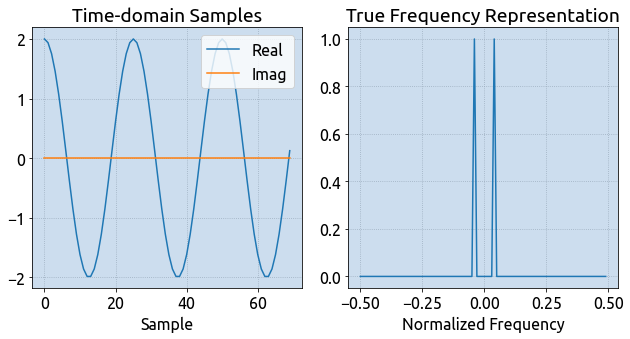

In [49]:
''' Plot Signal '''
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Ubuntu"
fig, ax = plt.subplots(1, 2, figsize=(9, 5))

ax[0].plot(y.real, label='Real')
ax[0].plot(y.imag, label='Imag')
ax[0].set_title("Time-domain Samples")
ax[0].set_xlabel("Sample")
ax[0].set_facecolor("#CCDDEE")
ax[0].grid(color='#99AABB', linestyle=':')
ax[0].legend()

ax[1].plot(fft.fftshift(fgrid), fft.fftshift(x))
ax[1].set_title("True Frequency Representation")
ax[1].set_xlabel("Normalized Frequency")
ax[1].set_facecolor("#CCDDEE")
ax[1].grid(color='#99AABB', linestyle=':')

plt.tight_layout()
plt.show()

In [27]:
''' Process DeepFreq Network ''' 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model paths
fr_path = 'pretrained_models/DeepFreq/frequency_representation_module.pth'
fc_path = 'pretrained_models/DeepFreq/frequency_counting_module.pth'
data_dir = 'jake_dataset'

# Load models
fr_module, _, _, _, _ = util.load(fr_path, 'fr', device)
fc_module, _, _, _, _ = util.load(fc_path, 'fc', device)
fr_module.cpu()
fr_module.eval()
fc_module.cpu()
fc_module.eval()

print()

In [28]:
''' DeepFreq Representation '''
# Process signal with network
def deepFreq(y):
    y_df = np.stack([y.real, y.imag], axis=0).astype(np.float32)
    y_df = np.moveaxis(y_df, -1, 0)
    with torch.no_grad():
        S_df = fr_module(torch.tensor(y_df))
    S_df = S_df.numpy()
    return S_df

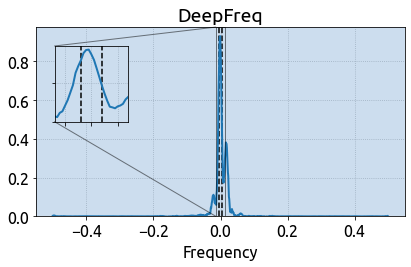

In [29]:
S_df = deepFreq(y)

# Plot
zoom_space = 0.01
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(fft.fftshift(fgrid), S_df[0], linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
ax.vlines(th, linestyle='--', ymin=0, ymax=y2, color='k', label='True frequency')
ax.set_ylim(0, y2)
ax.set_xlabel('Frequency')
ax.set_title('DeepFreq')
ax.grid(color='#99AABB', linestyle=':')
ax.set_facecolor('#CCDDEE')

# Zoomed plot
axins = ax.inset_axes([0.05, 0.5, 0.2, 0.4])
axins.plot(fft.fftshift(fgrid), S_df[0], linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
axins.vlines(th, linestyle='--', ymin=y1, ymax=y2, color='k', label='True frequency')
x1, x2 = th.min()-zoom_space, th.max()+zoom_space
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.grid(color='#99AABB', linestyle=':')
axins.set_facecolor('#CCDDEE')

ax.indicate_inset_zoom(axins, edgecolor="k")

plt.tight_layout()
plt.show()

In [50]:
''' Oversampled FFT, i.e. Minimum L2-norm Solution '''
def minL2(y, A):
    # Use pseudo-inverse of iFFT, i.e. FFT
    S_l2 = np.abs(1/M * A.conj().T @ y)
    return S_l2

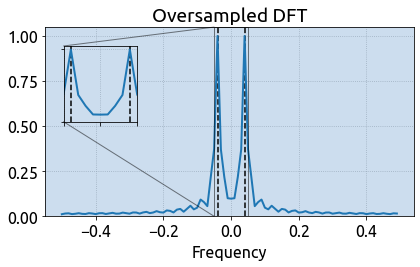

In [51]:
S_l2 = minL2(y, A)
# Plot
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(fft.fftshift(fgrid), fft.fftshift(S_l2), linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
ax.vlines(th, linestyle='--', ymin=0, ymax=y2, color='k', label='True frequency')
ax.set_ylim(0, y2)
ax.set_xlabel('Frequency')
ax.set_title('Oversampled DFT')
ax.grid(color='#99AABB', linestyle=':')
ax.set_facecolor('#CCDDEE')

# Zoomed plot
axins = ax.inset_axes([0.05, 0.5, 0.2, 0.4])
axins.plot(fft.fftshift(fgrid), fft.fftshift(S_l2), linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
axins.vlines(th, linestyle='--', ymin=y1, ymax=y2, color='k', label='True frequency')
x1, x2 = th.min()-zoom_space, th.max()+zoom_space
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.grid(color='#99AABB', linestyle=':')
axins.set_facecolor('#CCDDEE')

ax.indicate_inset_zoom(axins, edgecolor="k")

plt.tight_layout()
plt.show()

In [52]:
''' Minimum L1 Norm Solution '''
def minL1_CVX(y, A, sig):
    M, N = A.shape
    x = cp.Variable(N)
    cost = cp.norm(x, 1)
    constraint = [cp.norm(A @ x - y.flatten(), 2) <= 2*sig]
    #constraint = [A @ x == y[:,0]]
    prob = cp.Problem(cp.Minimize(cost), constraint)
    prob.solve()
    S_l1 = np.abs(x.value)
    return S_l1

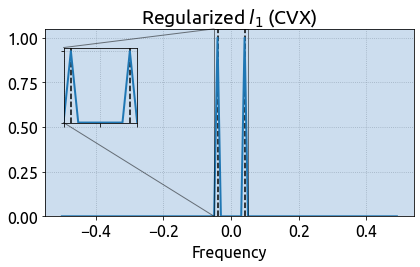

In [53]:
S_l1 = minL1_CVX(y, A, sig)
# Plot
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(fft.fftshift(fgrid), fft.fftshift(S_l1), linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
ax.vlines(th, linestyle='--', ymin=0, ymax=y2, color='k', label='True frequency')
ax.set_ylim(0, y2)
ax.set_xlabel('Frequency')
ax.set_title('Regularized $l_1$ (CVX)')
ax.grid(color='#99AABB', linestyle=':')
ax.set_facecolor('#CCDDEE')

# Zoomed plot
axins = ax.inset_axes([0.05, 0.5, 0.2, 0.4])
axins.plot(fft.fftshift(fgrid), fft.fftshift(S_l1), linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
axins.vlines(th, linestyle='--', ymin=y1, ymax=y2, color='k', label='True frequency')
x1, x2 = th.min()-zoom_space, th.max()+zoom_space
axins.set_xlim(x1, x2)
axins.set_ylim(0, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.grid(color='#99AABB', linestyle=':')
axins.set_facecolor('#CCDDEE')

ax.indicate_inset_zoom(axins, edgecolor="k")

plt.tight_layout()
plt.show()

In [54]:
''' Solving l1 by ISTA '''
import numpy as np
from scipy.linalg import norm

def relu(x):
    return x * (x > 0)
def soft_threshold(x, t):
    return np.sign(x) * relu(np.abs(x) - t)
def ista(A, b, l=1, maxit=50):
    M, N = A.shape
    #x = np.zeros([N, 1])
    # initialize with pseudo-inverse solution
    x = pinv(A) @ b
    L = norm(A) ** 2
    AHA = A.conj().T @ A
    AH = A.conj().T
    for _ in range(maxit):
        x = soft_threshold(x - (1/L * AHA @ x) + (1/L * AH @ b) , l / L)
    return x

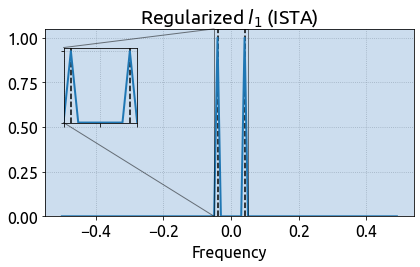

In [55]:
l = 50
maxit = 600
S_ista = np.abs(ista(A, y, l, maxit)) 
S_ista /= S_ista.max()

# Plot
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(fft.fftshift(fgrid), fft.fftshift(S_ista), linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
ax.vlines(th, linestyle='--', ymin=0, ymax=y2, color='k', label='True frequency')
ax.set_ylim(0, y2)
ax.set_xlabel('Frequency')
ax.set_title('Regularized $l_1$ (ISTA)')
ax.grid(color='#99AABB', linestyle=':')
ax.set_facecolor('#CCDDEE')

# Zoomed plot
axins = ax.inset_axes([0.05, 0.5, 0.2, 0.4])
axins.plot(fft.fftshift(fgrid), fft.fftshift(S_ista), linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
axins.vlines(th, linestyle='--', ymin=y1, ymax=y2, color='k', label='True frequency')
x1, x2 = th.min()-zoom_space, th.max()+zoom_space
axins.set_xlim(x1, x2)
axins.set_ylim(0, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.grid(color='#99AABB', linestyle=':')
axins.set_facecolor('#CCDDEE')

ax.indicate_inset_zoom(axins, edgecolor="k")

plt.tight_layout()
plt.show()

In [56]:
''' Single Snapshot MUSIC '''
def ssMusic(y, A, k):
    M, N =  A.shape
    L = M//2
    Hkl = hankel(y[:L+1], y[L:])
    U, s, _ = svd(Hkl, full_matrices=True)
    U2 = U[:, k:] # must know source number
    projection = norm(U2.conj().T @ A[:L+1, :], axis=0)
    S_ssm = 1/projection
    S_ssm /= S_ssm.max()
    return S_ssm

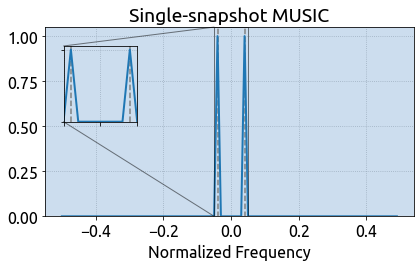

In [57]:
S_ssm = ssMusic(y, A, len(th))
# Plot
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(fft.fftshift(fgrid), fft.fftshift(S_ssm), linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
ax.vlines(th, linestyle='--', ymin=y1, ymax=y2, color='gray', label='True frequency')
ax.set_ylim(0, y2)
ax.set_xlabel('Normalized Frequency')
ax.set_title('Single-snapshot MUSIC')
ax.grid(color='#99AABB', linestyle=':')
ax.set_facecolor('#CCDDEE')

# Zoomed plot
axins = ax.inset_axes([0.05, 0.5, 0.2, 0.4])
axins.plot(fft.fftshift(fgrid), fft.fftshift(S_ssm), linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
axins.vlines(th, linestyle='--', ymin=y1, ymax=y2, color='gray', label='True frequency')
x1, x2 = th.min()-zoom_space, th.max()+zoom_space
axins.set_xlim(x1, x2)
axins.set_ylim(0, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.grid(color='#99AABB', linestyle=':')
axins.set_facecolor('#CCDDEE')

ax.indicate_inset_zoom(axins, edgecolor="k")

plt.tight_layout()
plt.show()

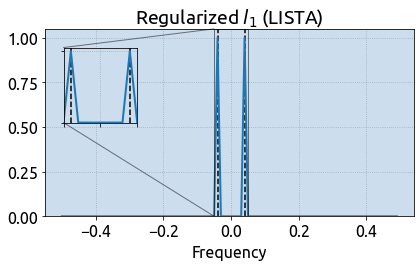

In [58]:
''' Solve with LISTA '''
def Aop(A, x):
    return torch.matmul(A,x)

def softthr(x, thr):
    z = torch.abs(x) - thr
    z = z * torch.sign(x) * (torch.abs(x) > thr).type(x.dtype) 
    return z

def pbnet(A, alpha, lamb, x0, y_meas, K, testFlag=True):

    x = x0.detach().clone()
    x.requires_grad = True
    
    AHA = torch.matmul(torch.transpose(A, 0, 1), A)
    AHy = torch.matmul(torch.transpose(A, 0, 1), y_meas)

    if testFlag: y_meas = y_meas.detach()
            
    for kk in range(K):
        y_est = Aop(A,x)
        g = torch.matmul(AHA, x) - AHy
        
        x = x - alpha*g           # gradient update
        x = softthr(x, lamb*alpha)   # proximal update
        
    return x

# Need to represent complex numbers as matrix
A_repr = np.block([
    [A.real, -A.imag],
    [A.imag, A.real]
])
y_repr = np.block([
    [y.real, -y.imag],
    [y.imag, y.real]
])

# process for network
A_torch = torch.from_numpy(A_repr)
y_torch = torch.from_numpy(y_repr)
x_init = torch.from_numpy(pinv(A_repr) @ y_repr)
x0 = x_init.detach().clone()
emax = np.max(abs(np.linalg.eig(A.T @ A)[0]))

max_iter = 600
alpha = 1
thr = 40

alpha /= emax

# evaluate lista
x_lista = pbnet(A_torch.to('cpu'), alpha, thr, x0.to('cpu'), y_torch.to('cpu'), max_iter, testFlag=True).detach().cpu().numpy()

# Convert back to complex form
S_lista = np.zeros(N, dtype=complex)
S_lista.real = x_lista[:N, 0]
S_lista.imag = x_lista[N:, 0]
S_lista = np.abs(S_lista)
S_lista = S_lista / S_lista.max()

# Plot
zoom_space = 0.01
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(fft.fftshift(fgrid), fft.fftshift(S_lista), linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
ax.vlines(th, linestyle='--', ymin=0, ymax=y2, color='k', label='True frequency')
ax.set_ylim(0, y2)
ax.set_xlabel('Frequency')
ax.set_title('Regularized $l_1$ (LISTA)')
ax.grid(color='#99AABB', linestyle=':')
ax.set_facecolor('#CCDDEE')

# Zoomed plot
axins = ax.inset_axes([0.05, 0.5, 0.2, 0.4])
axins.plot(fft.fftshift(fgrid), fft.fftshift(S_lista), linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
axins.vlines(th, linestyle='--', ymin=y1, ymax=y2, color='k', label='True frequency')
x1, x2 = th.min()-zoom_space, th.max()+zoom_space
axins.set_xlim(x1, x2)
axins.set_ylim(0, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.grid(color='#99AABB', linestyle=':')
axins.set_facecolor('#CCDDEE')

ax.indicate_inset_zoom(axins, edgecolor="k")

plt.tight_layout()
plt.show()

In [59]:
''' SPICE '''
def spice(y, A, iters=10, mode="SPICE"):
    M, N = A.shape
    B = np.hstack([A, np.eye(M)]).astype(complex)
    p = np.ones(N + M).astype(complex)
    w = norm(B, axis=0)
    
    for i in range(iters):
        R_inv = pinv(B @ np.diag(p) @ B.conj().T)
        term = np.abs(B.conj().T @ R_inv @ y.flatten())

        if mode == "SPICE":
            p = p * term * w
        elif mode == "SLIM":
            p = p**2 * term**2
        elif mode == "IAA":
            p = np.sqrt(p) * term / np.diag((B.conj().T @ R_inv @ B).real)

        p /= p.max()

    S_spice = np.abs(p[:N])
    return S_spice

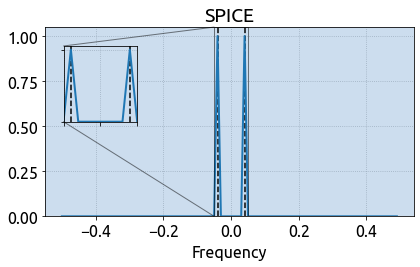

In [60]:
S_spice = spice(y, A, mode="SLIM")

# Plot
zoom_space = 0.01
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(fft.fftshift(fgrid), fft.fftshift(S_spice), linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
ax.vlines(th, linestyle='--', ymin=0, ymax=y2, color='k', label='True frequency')
ax.set_ylim(0, y2)
ax.set_xlabel('Frequency')
ax.set_title('SPICE')
ax.grid(color='#99AABB', linestyle=':')
ax.set_facecolor('#CCDDEE')

# Zoomed plot
axins = ax.inset_axes([0.05, 0.5, 0.2, 0.4])
axins.plot(fft.fftshift(fgrid), fft.fftshift(S_spice), linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
axins.vlines(th, linestyle='--', ymin=y1, ymax=y2, color='k', label='True frequency')
x1, x2 = th.min()-zoom_space, th.max()+zoom_space
axins.set_xlim(x1, x2)
axins.set_ylim(0, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.grid(color='#99AABB', linestyle=':')
axins.set_facecolor('#CCDDEE')

ax.indicate_inset_zoom(axins, edgecolor="k")

plt.tight_layout()
plt.show()

In [ ]:
''' Experiments '''
MC = 1000 # number of monte carlo trials

# signal/measurement parameters
M = 50
N = 1000

K = [2] # source numbers to test
Sig = [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2]

results = np.zeros([len(K), len(Sig), 2], dtype=float)
ii = 1
for i, k in enumerate(K): 
    for j, sig in enumerate(Sig): 
        for _ in range(MC):
            c = np.ones(k)
            th_ind = np.random.choice(N, size=k, replace=False)
            x, y, n, A, fgrid = buildOnGridSinusoid(N, M, sig, c, th_ind)
            S_list = []
            S_list.append(ssMusic(y, A, k))
            S_list.append(spice(y, A))

            for t, S in enumerate(S_list):
                peak_ind, peak_info = find_peaks(np.abs(S.flatten()), height=0)    
                peak_height = peak_info['peak_heights']
                peak_sortind = peak_ind[peak_height.argsort()]
                pred_peaks = peak_sortind[-k:]
        
                ssr = np.mean(np.sort(th_ind) == np.sort(pred_peaks))
                results[i, j, t] += ssr / MC

            clear_output()
            print(ii, '/', len(K)*len(Sig)*MC)
            ii += 1


In [ ]:
plt.figure()
plt.plot(Sig, 1-results[..., 0].mean(axis=0))
plt.plot(Sig, 1-results[..., 1].mean(axis=0))